In [1]:
# Vertexing Test File for AN-19-154 Work

# Coders: Nathan Suri, Caltech
# Date: September 24, 2019
# LPC LLP Group

# Description
# Study and investigate the impact of vertexing

# Action Plan
# Understand vertex setup in ntuple
# Test viability of inclusion radius for improving signal/bkg discrimination

# Notes/Conclusions
# @nasurijr: Further reductions in inclusion radius lower the signal efficiency for a fixed rejection power. 
        # This is most likely on account of the signal clusters being wider than the background.

In [2]:
# User specifics
# Setups pwd location for data files and imports of special ROOT utilities

work_location = input("Username: ")
if work_location == 'nasurijr':
    pwd = '/nfshome/nasurijr/LLP_analysis/delayed_jet_analyzer/'
    
    # Sets display width
    from IPython.core.display import display, HTML
    display(HTML("<style>.container { width:85% !important; }</style>"))
    
# elif work_location == '<Insert Tier2 username here>':
#     pwd = '/home/cms/delayed_jet_analyzer/'

Username: nasurijr


# Imports

In [3]:
# Imports necessary utilities and modules

import ROOT as rt
import root_numpy as rtnp
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist
from collections import Counter 
import datetime
import pytz

# Graph/histo utilities from ROOT
# Contained within the delayed_jet_analyzer repository
import sys
sys.path.append(pwd+'lib')
from histo_utilities import create_TH1D, create_TH2D, create_TGraph, std_color_list

# Used for extracting the TTree structure from each datafile
import os
import uproot

# Used for creating user-readable tables
from prettytable import PrettyTable

# Imports jet clustering algorithm (FastJet)
from pyjet import cluster

donotdelete = []

Welcome to JupyROOT 6.18/02


In [5]:
# Setups dictionaries for storing data from MC/data ntuples
fpath = {}
tree = {}
NEvents = {}

data_path = pwd+'data/'

# Background Samples
fpath['WJetsToLNu'] = data_path + 'WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8_1pb_weighted.root'

# Signal Samples 
fpath['m55ct10m'] = data_path + 'WH_HToSSTobbbb_WToLNu_MH-125_MS-55_ctauS-10000_TuneCUETP8M1_13TeV-powheg-pythia8_1pb_weighted.root'

for k,v in fpath.items():
    print(str(datetime.datetime.now(pytz.timezone('US/Pacific'))))
    print(k, v)
    root_dir = uproot.open(v) 
    tree[k] = root_dir['MuonSystem']
    NEvents[k] = root_dir['NEvents'][1]

2019-09-24 10:00:28.658233-07:00
WJetsToLNu /nfshome/nasurijr/LLP_analysis/delayed_jet_analyzer/data/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8_1pb_weighted.root
2019-09-24 10:00:28.753234-07:00
m55ct10m /nfshome/nasurijr/LLP_analysis/delayed_jet_analyzer/data/WH_HToSSTobbbb_WToLNu_MH-125_MS-55_ctauS-10000_TuneCUETP8M1_13TeV-powheg-pythia8_1pb_weighted.root


## Name TTree Objects

In [7]:
# Bookkeeping: Defines the TTrees from the read datafiles
# Names displayed in README.md table

T_m55ct10m = tree['m55ct10m']
T_wjets = tree['WJetsToLNu']

In [11]:
# Bookkeeping: Creates a dictionary for iterating over all of the datafiles and 
#              converting the relevant branches to numpy arrays
# Names displayed in README.md table

# data_trees = {'m55ct10m_wh_bbbb_minus': T_m55_ct10_minus, 'm55ct10m_wh_bbbb_plus': T_m55_ct10_plus, 'WJetsToLNu': T_wjets, 'm15ct10000mm': T_m15_ct10}

data_trees = {'m55ct10m': T_m55ct10m, 'WJetsToLNu': T_wjets}

# Define and Store Variables

In [113]:
# Variable Definitions
# Creates dictionaries for variables to be analyzed
# The dictionaries will contain the variable arrays for each datafile with a relevant key

# General Information
eventNum = {}
lumiNum = {}
weight = {}

# Standard CSC vars
nCsc = {}
csc_z = {}
csc_x = {}
csc_y = {}
csc_eta = {}
csc_phi = {}
csc_t = {}
csc_r = {}
nCsc_pop = {}

# CSC Vectors
csc_dir_x = {}
csc_dir_y = {}
csc_dir_z = {}

# Boolean Vetoes
nCsc_jet_veto = {}
nCsc_combo_veto = {}

# Vertexing
csc_vert_r = {}
csc_vert_z = {}
csc_vert_dis = {}
csc_vert_size_1 = {}
csc_vert_size_5 = {}
csc_vert_size_10 = {}
csc_vert_size_15 = {}
csc_vert_size_20 = {}
csc_vert_size_30 = {}

In [114]:
print('Start: ' + str(datetime.datetime.now(pytz.timezone('US/Pacific'))))

for species, arbor in data_trees.items():
    
    # General Information
    eventNum[species] = arbor['evtNum'].array()
    lumiNum[species] = arbor['lumiSec'].array()
    weight[species] = arbor['weight'].array()
    
    # Standard CSC vars
    nCsc[species] = arbor['nCsc'].array()
    nCsc_pop[species] = arbor['cscClusterSize'].array()
    csc_z[species] = arbor['cscZ'].array()
    csc_x[species] = arbor['cscX'].array()
    csc_y[species] = arbor['cscY'].array()
    csc_t[species] = arbor['cscT'].array()
    csc_eta[species] = arbor['cscEta'].array()
    csc_phi[species] = arbor['cscPhi'].array()
        
    # CSC Vectors
    csc_dir_x[species] = arbor['cscDirectionX'].array()
    csc_dir_y[species] = arbor['cscDirectionY'].array()
    csc_dir_z[species] = arbor['cscDirectionZ'].array()
    
    # Boolean Vetoes
    nCsc_jet_veto[species] = arbor['nCsc_JetVetoCluster0p4_Me1112Veto'].array()
    nCsc_combo_veto[species] = arbor['nCsc_JetMuonVetoCluster0p4_Me1112Veto'].array()
    
    # Vertexing
    csc_vert_r[species] = arbor['cscClusterVertexR'].array()
    csc_vert_z[species] = arbor['cscClusterVertexZ'].array()
    csc_vert_dis[species] = arbor['cscClusterVertexDis'].array()
    csc_vert_size_1[species] = arbor['cscClusterVertexN1'].array()
    csc_vert_size_5[species] = arbor['cscClusterVertexN5'].array()
    csc_vert_size_10[species] = arbor['cscClusterVertexN10'].array()
    csc_vert_size_15[species] = arbor['cscClusterVertexN15'].array()
    csc_vert_size_20[species] = arbor['cscClusterVertexN20'].array()
    csc_vert_size_30[species] = arbor['cscClusterVertexN'].array()
    
    print(species + ': ' +str(datetime.datetime.now(pytz.timezone('US/Pacific'))))

Start: 2019-09-24 11:36:25.485127-07:00
m55ct10m: 2019-09-24 11:36:25.610384-07:00
WJetsToLNu: 2019-09-24 11:36:32.489240-07:00


# Vertexing Study

## N<sub>CSC</sub> following $\Delta R = 0.4$ Jet/Muon, ME 1/1, 1/2 Removal Vetoes

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


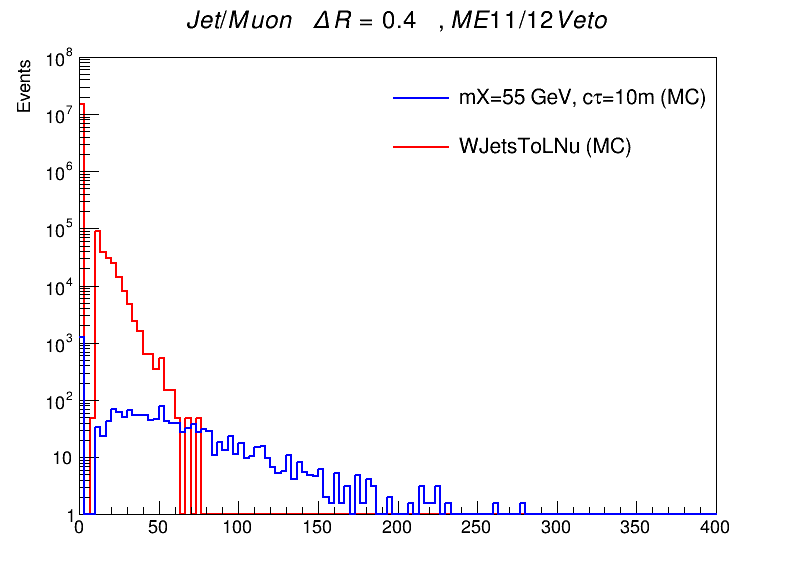

In [331]:
c = rt.TCanvas('c','c', 800, 600)
h = {}

h['m55ct10m_wh_bbbb'] = create_TH1D(nCsc_combo_veto['m55ct10m'], axis_title=['m55ct10m_wh_bbbb', 'Events'], name='m55ct10m_wh_bbbb', binning=[150,0,500], weights=weight['m55ct10m']*137000)
h['m55ct10m_wh_bbbb'].SetLineColor(4)

h['nCsc_wjets'] = create_TH1D(nCsc_combo_veto['WJetsToLNu'], axis_title=['nCsc_wjets', 'Events'], name='nCsc_wjets', binning=[150,0,500], weights=weight['WJetsToLNu']*137000)
h['nCsc_wjets'].SetLineColor(2)


c.SetLogy()

h['m55ct10m_wh_bbbb'].SetLineWidth(2)

h['nCsc_wjets'].SetLineWidth(2)


h['nCsc_wjets'].GetYaxis().SetRangeUser(1,10**8)

h['nCsc_wjets'].GetXaxis().SetRangeUser(0,400)


h['nCsc_wjets'].SetStats(0)
h['nCsc_wjets'].SetTitle("Jet/Muon $\Delta R = 0.4$, ME 11/12 Veto")
h['nCsc_wjets'].SetXTitle("")


h['nCsc_wjets'].Draw('histo')
h['m55ct10m_wh_bbbb'].Draw('histo+same')


legend = rt.TLegend(0.48,0.70,0.87,0.87);
legend.SetTextSize(0.04);
legend.SetBorderSize(0);
legend.AddEntry( h['m55ct10m_wh_bbbb'], "mX=55 GeV, c#tau=10m (MC)" , "L");
legend.AddEntry( h['nCsc_wjets'], "WJetsToLNu (MC)" , "L");
legend.Draw();

c.Draw()

## Size of Vertex Groups

In [323]:
# Takes the inclusion radius and returns a new WH weight array for WH samples that is the length of the flattened vertex array

def wh_weight(inc_rad):
    wh_weight_arr = np.array([])
    evt_counter = 0
    if inc_rad == 1:
        for vert in csc_vert_size_1['m55ct10m']:
            wh_weight_arr = np.append(wh_weight_arr, np.full(len(vert), weight['m55ct10m'][evt_counter]))
            evt_counter += 1
    elif inc_rad == 5:
        for vert in csc_vert_size_5['m55ct10m']:
            wh_weight_arr = np.append(wh_weight_arr, np.full(len(vert), weight['m55ct10m'][evt_counter]))
            evt_counter += 1
    elif inc_rad == 10:
        for vert in csc_vert_size_10['m55ct10m']:
            wh_weight_arr = np.append(wh_weight_arr, np.full(len(vert), weight['m55ct10m'][evt_counter]))
            evt_counter += 1
    elif inc_rad == 15:
        for vert in csc_vert_size_15['m55ct10m']:
            wh_weight_arr = np.append(wh_weight_arr, np.full(len(vert), weight['m55ct10m'][evt_counter]))
            evt_counter += 1
    elif inc_rad == 20:
        for vert in csc_vert_size_20['m55ct10m']:
            wh_weight_arr = np.append(wh_weight_arr, np.full(len(vert), weight['m55ct10m'][evt_counter]))
            evt_counter += 1
    elif inc_rad == 30:
        for vert in csc_vert_size_30['m55ct10m']:
            wh_weight_arr = np.append(wh_weight_arr, np.full(len(vert), weight['m55ct10m'][evt_counter]))
            evt_counter += 1
    return wh_weight_arr

In [324]:
# Creates WH and WJetsToLNu weight arrays normalized to 137 fb^-1 integrated luminosity

weights_vertex_1 = {}
weights_vertex_5 = {}
weights_vertex_10 = {}
weights_vertex_15 = {}
weights_vertex_20 = {}
weights_vertex_30 = {}

for doru in data_trees.keys():
    if doru == 'm55ct10m':
        weights_vertex_1[doru] = wh_weight(1)*137000
        weights_vertex_5[doru] = wh_weight(5)*137000
        weights_vertex_10[doru] = wh_weight(10)*137000
        weights_vertex_15[doru] = wh_weight(15)*137000
        weights_vertex_20[doru] = wh_weight(20)*137000
        weights_vertex_30[doru] = wh_weight(30)*137000
    else:
        weights_vertex_1[doru] = np.full(len(csc_vert_size_1[doru].flatten()), weight[doru][0]*137000)
        weights_vertex_5[doru] = np.full(len(csc_vert_size_5[doru].flatten()), weight[doru][0]*137000)
        weights_vertex_10[doru] = np.full(len(csc_vert_size_10[doru].flatten()), weight[doru][0]*137000)
        weights_vertex_15[doru] = np.full(len(csc_vert_size_15[doru].flatten()), weight[doru][0]*137000)
        weights_vertex_20[doru] = np.full(len(csc_vert_size_20[doru].flatten()), weight[doru][0]*137000)
        weights_vertex_30[doru] = np.full(len(csc_vert_size_30[doru].flatten()), weight[doru][0]*137000)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TROOT::Append>: Replacing existing TH1: csc_vert_1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: csc_vert_5 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: csc_vert_10 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: csc_vert_15 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: csc_vert_20 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: csc_vert_30 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: csc_vert_1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: csc_vert_5 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: csc_vert_10 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: csc_vert_15 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existi

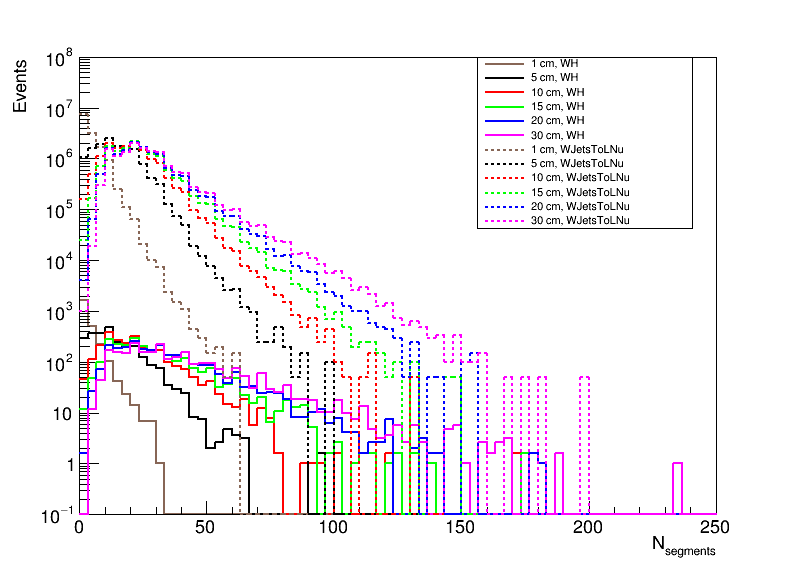

In [335]:
# Plots the population of the vertex groups for both WH and WJetsToLNu

c1 = rt.TCanvas('c1','c1', 800, 600)

h['csc_vert_1_wh'] = create_TH1D(csc_vert_size_1['m55ct10m'].flatten(), axis_title=['csc_vert_1', 'Events'], name='csc_vert_1', binning=[150,0,500], weights = weights_vertex_1['m55ct10m'])
h['csc_vert_1_wh'].SetLineColor(28)
h['csc_vert_1_wh'].SetLineWidth(2)

h['csc_vert_5_wh'] = create_TH1D(csc_vert_size_5['m55ct10m'].flatten(), axis_title=['csc_vert_5', 'Events'], name='csc_vert_5', binning=[150,0,500], weights = weights_vertex_5['m55ct10m'])
h['csc_vert_5_wh'].SetLineColor(1)
h['csc_vert_5_wh'].SetLineWidth(2)

h['csc_vert_10_wh'] = create_TH1D(csc_vert_size_10['m55ct10m'].flatten(), axis_title=['csc_vert_10', 'Events'], name='csc_vert_10', binning=[150,0,500], weights = weights_vertex_10['m55ct10m'])
h['csc_vert_10_wh'].SetLineColor(2)
h['csc_vert_10_wh'].SetLineWidth(2)

h['csc_vert_15_wh'] = create_TH1D(csc_vert_size_15['m55ct10m'].flatten(), axis_title=['csc_vert_15', 'Events'], name='csc_vert_15', binning=[150,0,500], weights = weights_vertex_15['m55ct10m'])
h['csc_vert_15_wh'].SetLineColor(3)
h['csc_vert_15_wh'].SetLineWidth(2)

h['csc_vert_20_wh'] = create_TH1D(csc_vert_size_20['m55ct10m'].flatten(), axis_title=['csc_vert_20', 'Events'], name='csc_vert_20', binning=[150,0,500], weights = weights_vertex_20['m55ct10m'])
h['csc_vert_20_wh'].SetLineColor(4)
h['csc_vert_20_wh'].SetLineWidth(2)

h['csc_vert_30_wh'] = create_TH1D(csc_vert_size_30['m55ct10m'].flatten(), axis_title=['csc_vert_30', 'Events'], name='csc_vert_30', binning=[150,0,500], weights = weights_vertex_30['m55ct10m'])
h['csc_vert_30_wh'].SetLineColor(6)
h['csc_vert_30_wh'].SetLineWidth(2)

####################

h['csc_vert_1_wjets'] = create_TH1D(csc_vert_size_1['WJetsToLNu'].flatten(), axis_title=['csc_vert_1', 'Events'], name='csc_vert_1', binning=[150,0,500], weights = weights_vertex_1['WJetsToLNu'])
h['csc_vert_1_wjets'].SetLineColor(28)
h['csc_vert_1_wjets'].SetLineWidth(2)
h['csc_vert_1_wjets'].SetLineStyle(2)

h['csc_vert_5_wjets'] = create_TH1D(csc_vert_size_5['WJetsToLNu'].flatten(), axis_title=['csc_vert_5', 'Events'], name='csc_vert_5', binning=[150,0,500], weights = weights_vertex_5['WJetsToLNu'])
h['csc_vert_5_wjets'].SetLineColor(1)
h['csc_vert_5_wjets'].SetLineWidth(2)
h['csc_vert_5_wjets'].SetLineStyle(2)

h['csc_vert_10_wjets'] = create_TH1D(csc_vert_size_10['WJetsToLNu'].flatten(), axis_title=['csc_vert_10', 'Events'], name='csc_vert_10', binning=[150,0,500], weights = weights_vertex_10['WJetsToLNu'])
h['csc_vert_10_wjets'].SetLineColor(2)
h['csc_vert_10_wjets'].SetLineWidth(2)
h['csc_vert_10_wjets'].SetLineStyle(2)

h['csc_vert_15_wjets'] = create_TH1D(csc_vert_size_15['WJetsToLNu'].flatten(), axis_title=['csc_vert_15', 'Events'], name='csc_vert_15', binning=[150,0,500], weights = weights_vertex_15['WJetsToLNu'])
h['csc_vert_15_wjets'].SetLineColor(3)
h['csc_vert_15_wjets'].SetLineWidth(2)
h['csc_vert_15_wjets'].SetLineStyle(2)

h['csc_vert_20_wjets'] = create_TH1D(csc_vert_size_20['WJetsToLNu'].flatten(), axis_title=['csc_vert_20', 'Events'], name='csc_vert_20', binning=[150,0,500], weights = weights_vertex_20['WJetsToLNu'])
h['csc_vert_20_wjets'].SetLineColor(4)
h['csc_vert_20_wjets'].SetLineWidth(2)
h['csc_vert_20_wjets'].SetLineStyle(2)

h['csc_vert_30_wjets'] = create_TH1D(csc_vert_size_30['WJetsToLNu'].flatten(), axis_title=['csc_vert_30', 'Events'], name='csc_vert_30', binning=[150,0,500], weights = weights_vertex_30['WJetsToLNu'])
h['csc_vert_30_wjets'].SetLineColor(6)
h['csc_vert_30_wjets'].SetLineWidth(2)
h['csc_vert_30_wjets'].SetLineStyle(2)

c1.SetLogy()


h['csc_vert_1_wh'].GetYaxis().SetRangeUser(10**-1,10**8)

h['csc_vert_1_wh'].GetXaxis().SetRangeUser(0,250)


h['csc_vert_1_wh'].SetStats(0)
h['csc_vert_1_wh'].SetTitle("")
h['csc_vert_1_wh'].SetXTitle("N_{segments}")


h['csc_vert_1_wh'].Draw('histo')
h['csc_vert_5_wh'].Draw('histo+same')
h['csc_vert_10_wh'].Draw('histo+same')
h['csc_vert_15_wh'].Draw('histo+same')
h['csc_vert_20_wh'].Draw('histo+same')
h['csc_vert_30_wh'].Draw('histo+same')
##############
h['csc_vert_1_wjets'].Draw('histo+same')
h['csc_vert_5_wjets'].Draw('histo+same')
h['csc_vert_10_wjets'].Draw('histo+same')
h['csc_vert_15_wjets'].Draw('histo+same')
h['csc_vert_20_wjets'].Draw('histo+same')
h['csc_vert_30_wjets'].Draw('histo+same')


legend = rt.TLegend(0.6,0.60,0.87,0.9);
legend.SetTextSize(0.02);
legend.SetBorderSize(1);
legend.AddEntry( h['csc_vert_1_wh'], "1 cm, WH" , "L");
legend.AddEntry( h['csc_vert_5_wh'], "5 cm, WH" , "L");
legend.AddEntry( h['csc_vert_10_wh'], "10 cm, WH" , "L");
legend.AddEntry( h['csc_vert_15_wh'], "15 cm, WH" , "L");
legend.AddEntry( h['csc_vert_20_wh'], "20 cm, WH" , "L");
legend.AddEntry( h['csc_vert_30_wh'], "30 cm, WH" , "L");
#############
legend.AddEntry( h['csc_vert_1_wjets'], "1 cm, WJetsToLNu" , "L");
legend.AddEntry( h['csc_vert_5_wjets'], "5 cm, WJetsToLNu" , "L");
legend.AddEntry( h['csc_vert_10_wjets'], "10 cm, WJetsToLNu" , "L");
legend.AddEntry( h['csc_vert_15_wjets'], "15 cm, WJetsToLNu" , "L");
legend.AddEntry( h['csc_vert_20_wjets'], "20 cm, WJetsToLNu" , "L");
legend.AddEntry( h['csc_vert_30_wjets'], "30 cm, WJetsToLNu" , "L");
legend.Draw();

c1.Draw()

In [286]:
# Shows promising viability of cuts/adjustsments using inclusion radius 

print(np.count_nonzero(csc_vert_size_10['WJetsToLNu'].flatten()>130))
print(np.count_nonzero(csc_vert_size_10['m55ct10m'].flatten()>130))

0
1


## ROC Curves: Vertex Group Size

In [336]:
# ROC Curve for WH/WJetsToLNu Samples: Vertex Group Size

eff_ncsc = {}
rejection_power = {}
ncsc_var_x = np.array([])

for data_type in data_trees.keys():
    eff_ncsc[data_type] = {}
    
    eff_ncsc[data_type]['incRad_1'] = np.array([])
    eff_ncsc[data_type]['incRad_5'] = np.array([])
    eff_ncsc[data_type]['incRad_10'] = np.array([])
    eff_ncsc[data_type]['incRad_15'] = np.array([])
    eff_ncsc[data_type]['incRad_20'] = np.array([])
    eff_ncsc[data_type]['incRad_30'] = np.array([])
    
    for hit_thresh in range(0, 200):
        ncsc_var_x = np.append(ncsc_var_x, hit_thresh)

       # Baseline ROCs
        eff_ncsc[data_type]['incRad_1'] = np.append(eff_ncsc[data_type]['incRad_1'], np.count_nonzero(np.array(csc_vert_size_1[data_type].flatten())>hit_thresh)/len(csc_vert_size_1[data_type].flatten()))
        eff_ncsc[data_type]['incRad_5'] = np.append(eff_ncsc[data_type]['incRad_5'], np.count_nonzero(np.array(csc_vert_size_5[data_type].flatten())>hit_thresh)/len(csc_vert_size_5[data_type].flatten()))
        eff_ncsc[data_type]['incRad_10'] = np.append(eff_ncsc[data_type]['incRad_10'], np.count_nonzero(np.array(csc_vert_size_10[data_type].flatten())>hit_thresh)/len(csc_vert_size_10[data_type].flatten()))
        eff_ncsc[data_type]['incRad_15'] = np.append(eff_ncsc[data_type]['incRad_15'], np.count_nonzero(np.array(csc_vert_size_15[data_type].flatten())>hit_thresh)/len(csc_vert_size_15[data_type].flatten()))
        eff_ncsc[data_type]['incRad_20'] = np.append(eff_ncsc[data_type]['incRad_20'], np.count_nonzero(np.array(csc_vert_size_20[data_type].flatten())>hit_thresh)/len(csc_vert_size_20[data_type].flatten()))
        eff_ncsc[data_type]['incRad_30'] = np.append(eff_ncsc[data_type]['incRad_30'], np.count_nonzero(np.array(csc_vert_size_30[data_type].flatten())>hit_thresh)/len(csc_vert_size_30[data_type].flatten()))
        
        
    # Rejection power calculation
    rejection_power[data_type] = {}
    
    rejection_power[data_type]['incRad_1'] = np.reciprocal(np.trim_zeros(eff_ncsc[data_type]['incRad_1']))
    rejection_power[data_type]['incRad_5'] = np.reciprocal(np.trim_zeros(eff_ncsc[data_type]['incRad_5']))
    rejection_power[data_type]['incRad_10'] = np.reciprocal(np.trim_zeros(eff_ncsc[data_type]['incRad_10']))
    rejection_power[data_type]['incRad_15'] = np.reciprocal(np.trim_zeros(eff_ncsc[data_type]['incRad_15']))
    rejection_power[data_type]['incRad_20'] = np.reciprocal(np.trim_zeros(eff_ncsc[data_type]['incRad_20']))
    rejection_power[data_type]['incRad_30'] = np.reciprocal(np.trim_zeros(eff_ncsc[data_type]['incRad_30']))
    
    print(data_type + ': ' +str(datetime.datetime.now(pytz.timezone('US/Pacific'))))

m55ct10m: 2019-09-24 16:15:02.482939-07:00
WJetsToLNu: 2019-09-24 16:15:03.092132-07:00


length of x and y are not equal!
length of x and y are not equal!
length of x and y are not equal!
length of x and y are not equal!
length of x and y are not equal!
length of x and y are not equal!


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_roc1


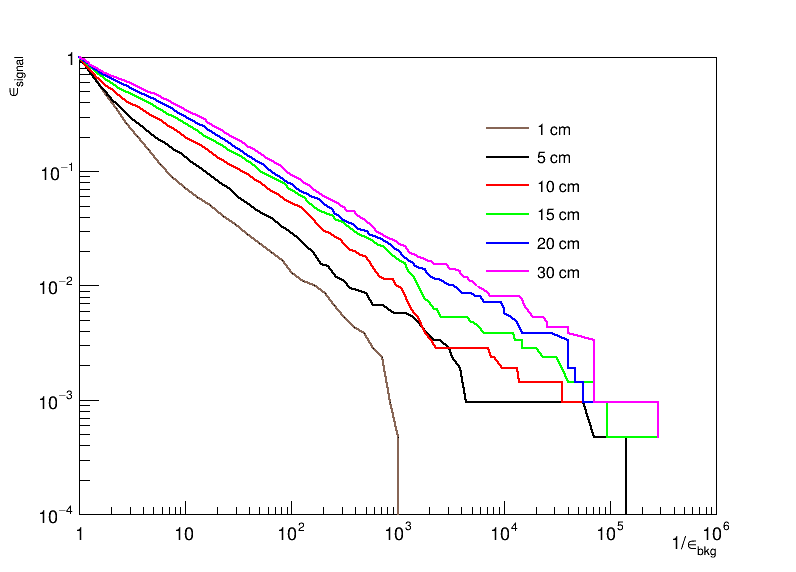

In [357]:
# Creates ROC curves for the signal efficiency of the m55ct10m signal sample against the WJetsToLNu samples using vertex group size thresholds 

c_roc1 = rt.TCanvas('c_roc1','c_roc1', 800, 600)

h['roc_curve_1'] = create_TGraph(rejection_power['WJetsToLNu']['incRad_1'], eff_ncsc['m55ct10m']['incRad_1'], axis_title=['1/#epsilon_{bkg}', '#epsilon_{signal}'])
h['roc_curve_5'] = create_TGraph(rejection_power['WJetsToLNu']['incRad_5'], eff_ncsc['m55ct10m']['incRad_5'], axis_title=['1/#epsilon_{bkg}', '#epsilon_{signal}'])
h['roc_curve_10'] = create_TGraph(rejection_power['WJetsToLNu']['incRad_10'], eff_ncsc['m55ct10m']['incRad_10'], axis_title=['1/#epsilon_{bkg}', '#epsilon_{signal}'])
h['roc_curve_15'] = create_TGraph(rejection_power['WJetsToLNu']['incRad_15'], eff_ncsc['m55ct10m']['incRad_15'], axis_title=['1/#epsilon_{bkg}', '#epsilon_{signal}'])
h['roc_curve_20'] = create_TGraph(rejection_power['WJetsToLNu']['incRad_20'], eff_ncsc['m55ct10m']['incRad_20'], axis_title=['1/#epsilon_{bkg}', '#epsilon_{signal}'])
h['roc_curve_30'] = create_TGraph(rejection_power['WJetsToLNu']['incRad_30'], eff_ncsc['m55ct10m']['incRad_30'], axis_title=['1/#epsilon_{bkg}', '#epsilon_{signal}'])


c_roc1.SetLogx()
c_roc1.SetLogy()

h['roc_curve_1'].SetTitle('')


h['roc_curve_1'].SetLineWidth(2)
h['roc_curve_5'].SetLineWidth(2)
h['roc_curve_10'].SetLineWidth(2)
h['roc_curve_15'].SetLineWidth(2)
h['roc_curve_20'].SetLineWidth(2)
h['roc_curve_30'].SetLineWidth(2)


h['roc_curve_1'].SetLineColor(28)
h['roc_curve_5'].SetLineColor(1)
h['roc_curve_10'].SetLineColor(2)
h['roc_curve_15'].SetLineColor(3)
h['roc_curve_20'].SetLineColor(4)
h['roc_curve_30'].SetLineColor(6)

h['roc_curve_1'].GetXaxis().SetLimits(10**0, 10**6)
h['roc_curve_1'].GetYaxis().SetRangeUser(10**-4,1)

h['roc_curve_1'].Draw()
h['roc_curve_5'].Draw('same')
h['roc_curve_10'].Draw('same')
h['roc_curve_15'].Draw('same')
h['roc_curve_20'].Draw('same')
h['roc_curve_30'].Draw('same')

legend = rt.TLegend(0.6,0.50,0.9,0.8);
legend.SetTextSize(0.03);
legend.SetBorderSize(0);

legend.AddEntry( h['roc_curve_1'], "1 cm", 'l');
legend.AddEntry( h['roc_curve_5'], "5 cm", 'l');
legend.AddEntry( h['roc_curve_10'], "10 cm", 'l');
legend.AddEntry( h['roc_curve_15'], "15 cm", 'l');
legend.AddEntry( h['roc_curve_20'], "20 cm", 'l');
legend.AddEntry( h['roc_curve_30'], "30 cm", 'l');

legend.Draw();

c_roc1.Draw()

## cscClusterVertexN::cscClusterSize

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2_1
Warning in <TROOT::Append>: Replacing existing TH1: clusterPop_vertN_0 (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2_2
Warning in <TROOT::Append>: Replacing existing TH1: clusterPop_vertN_0 (Potential memory leak).


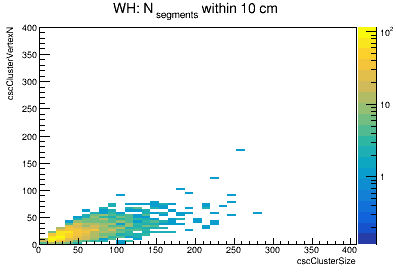

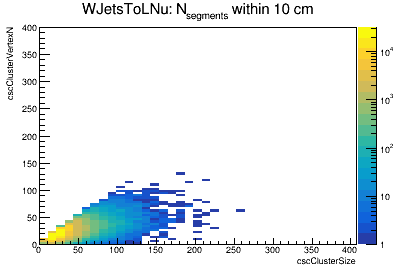

In [332]:
c2_1 = rt.TCanvas('c2_1','c2_1', 400, 300)

h['clusterPop_vertN_0'] = create_TH2D(np.column_stack((nCsc_pop['m55ct10m'].flatten(), csc_vert_size_10['m55ct10m'].flatten())), name='clusterPop_vertN_0', binning=[200, -1100, 1100, 100, 0, 400], axis_title=['gLLP_decay_vertex_z (cm)', 'N_{csc}', ''])

c2_1.SetLogz()
h['clusterPop_vertN_0'].SetStats(0)
h['clusterPop_vertN_0'].GetXaxis().SetRangeUser(0,400)
h['clusterPop_vertN_0'].SetTitle('WH: N_{segments} within 10 cm')
h['clusterPop_vertN_0'].SetXTitle('cscClusterSize')
h['clusterPop_vertN_0'].SetYTitle('cscClusterVertexN')
h['clusterPop_vertN_0'].Draw("colz")

c2_2 = rt.TCanvas('c2_2','c2_2', 400, 300)
h['clusterPop_vertN_bkg'] = create_TH2D(np.column_stack((nCsc_pop['WJetsToLNu'].flatten(), csc_vert_size_10['WJetsToLNu'].flatten())), name='clusterPop_vertN_0', binning=[200, -1100, 1100, 100, 0, 400], axis_title=['gLLP_decay_vertex_z (cm)', 'N_{csc}', ''])
c2_2.SetLogz()
h['clusterPop_vertN_bkg'].SetStats(0)
h['clusterPop_vertN_bkg'].GetXaxis().SetRangeUser(0,400)
h['clusterPop_vertN_bkg'].SetTitle('WJetsToLNu: N_{segments} within 10 cm')
h['clusterPop_vertN_bkg'].SetXTitle('cscClusterSize')
h['clusterPop_vertN_bkg'].SetYTitle('cscClusterVertexN')


h['clusterPop_vertN_bkg'].Draw("colz")
c2_1.Draw()
c2_2.Draw()

## Correlation Ratio of Cluster Size to Vertex Group Size

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c3
Warning in <TROOT::Append>: Replacing existing TH1: csc_vertRatio_1_wh (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: csc_vertRatio_5_wh (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: csc_vertRatio_10_wh (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: csc_vertRatio_15_wh (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: csc_vertRatio_20_wh (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: csc_vertRatio_30_wh (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: csc_vertRatio_1_wjets (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: csc_vertRatio_5_wjets (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: csc_vertRatio_10_wjets (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: 

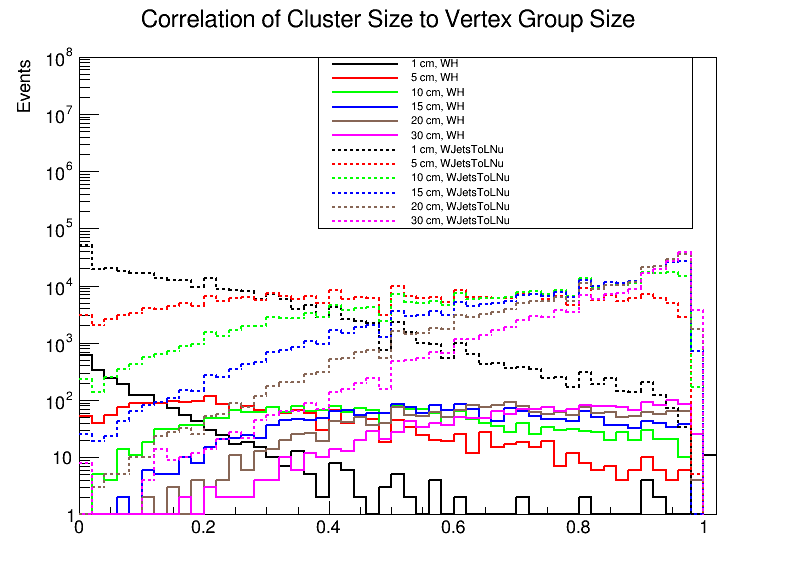

In [184]:
# Plots the ratio of cluster size to vertex group size for both WH and WJetsToLNu

c3 = rt.TCanvas('c3','c3', 800, 600)

h['csc_vertRatio_1_wh'] = create_TH1D(csc_vert_size_1['m55ct10m'].flatten()/nCsc_pop['m55ct10m'].flatten(), axis_title=['csc_vertRatio_1_wh', 'Events'], name='csc_vertRatio_1_wh', binning=[50,0,1])
h['csc_vertRatio_1_wh'].SetLineColor(1)
h['csc_vertRatio_1_wh'].SetLineWidth(2)

h['csc_vertRatio_5_wh'] = create_TH1D(csc_vert_size_5['m55ct10m'].flatten()/nCsc_pop['m55ct10m'].flatten(), axis_title=['csc_vertRatio_5_wh', 'Events'], name='csc_vertRatio_5_wh', binning=[50,0,1])
h['csc_vertRatio_5_wh'].SetLineColor(2)
h['csc_vertRatio_5_wh'].SetLineWidth(2)

h['csc_vertRatio_10_wh'] = create_TH1D(csc_vert_size_10['m55ct10m'].flatten()/nCsc_pop['m55ct10m'].flatten(), axis_title=['csc_vertRatio_10_wh', 'Events'], name='csc_vertRatio_10_wh', binning=[50,0,1])
h['csc_vertRatio_10_wh'].SetLineColor(3)
h['csc_vertRatio_10_wh'].SetLineWidth(2)

h['csc_vertRatio_15_wh'] = create_TH1D(csc_vert_size_15['m55ct10m'].flatten()/nCsc_pop['m55ct10m'].flatten(), axis_title=['csc_vertRatio_15_wh', 'Events'], name='csc_vertRatio_15_wh', binning=[50,0,1])
h['csc_vertRatio_15_wh'].SetLineColor(4)
h['csc_vertRatio_15_wh'].SetLineWidth(2)

h['csc_vertRatio_20_wh'] = create_TH1D(csc_vert_size_20['m55ct10m'].flatten()/nCsc_pop['m55ct10m'].flatten(), axis_title=['csc_vertRatio_20_wh', 'Events'], name='csc_vertRatio_20_wh', binning=[50,0,1])
h['csc_vertRatio_20_wh'].SetLineColor(28)
h['csc_vertRatio_20_wh'].SetLineWidth(2)

h['csc_vertRatio_30_wh'] = create_TH1D(csc_vert_size_30['m55ct10m'].flatten()/nCsc_pop['m55ct10m'].flatten(), axis_title=['csc_vertRatio_30_wh', 'Events'], name='csc_vertRatio_30_wh', binning=[50,0,1])
h['csc_vertRatio_30_wh'].SetLineColor(6)
h['csc_vertRatio_30_wh'].SetLineWidth(2)

###############

h['csc_vertRatio_1_wjets'] = create_TH1D(csc_vert_size_1['WJetsToLNu'].flatten()/nCsc_pop['WJetsToLNu'].flatten(), axis_title=['csc_vertRatio_1_wjets', 'Events'], name='csc_vertRatio_1_wjets', binning=[50,0,1])
h['csc_vertRatio_1_wjets'].SetLineColor(1)
h['csc_vertRatio_1_wjets'].SetLineWidth(2)
h['csc_vertRatio_1_wjets'].SetLineStyle(2)

h['csc_vertRatio_5_wjets'] = create_TH1D(csc_vert_size_5['WJetsToLNu'].flatten()/nCsc_pop['WJetsToLNu'].flatten(), axis_title=['csc_vertRatio_5_wjets', 'Events'], name='csc_vertRatio_5_wjets', binning=[50,0,1])
h['csc_vertRatio_5_wjets'].SetLineColor(2)
h['csc_vertRatio_5_wjets'].SetLineWidth(2)
h['csc_vertRatio_5_wjets'].SetLineStyle(2)

h['csc_vertRatio_10_wjets'] = create_TH1D(csc_vert_size_10['WJetsToLNu'].flatten()/nCsc_pop['WJetsToLNu'].flatten(), axis_title=['csc_vertRatio_10_wjets', 'Events'], name='csc_vertRatio_10_wjets', binning=[50,0,1])
h['csc_vertRatio_10_wjets'].SetLineColor(3)
h['csc_vertRatio_10_wjets'].SetLineWidth(2)
h['csc_vertRatio_10_wjets'].SetLineStyle(2)

h['csc_vertRatio_15_wjets'] = create_TH1D(csc_vert_size_15['WJetsToLNu'].flatten()/nCsc_pop['WJetsToLNu'].flatten(), axis_title=['csc_vertRatio_15_wjets', 'Events'], name='csc_vertRatio_15_wjets', binning=[50,0,1])
h['csc_vertRatio_15_wjets'].SetLineColor(4)
h['csc_vertRatio_15_wjets'].SetLineWidth(2)
h['csc_vertRatio_15_wjets'].SetLineStyle(2)

h['csc_vertRatio_20_wjets'] = create_TH1D(csc_vert_size_20['WJetsToLNu'].flatten()/nCsc_pop['WJetsToLNu'].flatten(), axis_title=['csc_vertRatio_20_wjets', 'Events'], name='csc_vertRatio_20_wjets', binning=[50,0,1])
h['csc_vertRatio_20_wjets'].SetLineColor(28)
h['csc_vertRatio_20_wjets'].SetLineWidth(2)
h['csc_vertRatio_20_wjets'].SetLineStyle(2)

h['csc_vertRatio_30_wjets'] = create_TH1D(csc_vert_size_30['WJetsToLNu'].flatten()/nCsc_pop['WJetsToLNu'].flatten(), axis_title=['csc_vertRatio_30_wjets', 'Events'], name='csc_vertRatio_30_wjets', binning=[50,0,1])
h['csc_vertRatio_30_wjets'].SetLineColor(6)
h['csc_vertRatio_30_wjets'].SetLineWidth(2)
h['csc_vertRatio_30_wjets'].SetLineStyle(2)


c3.SetLogy()


h['csc_vertRatio_1_wh'].GetYaxis().SetRangeUser(1,10**8)

h['csc_vertRatio_1_wh'].GetXaxis().SetRangeUser(0,2)


h['csc_vertRatio_1_wh'].SetStats(0)
h['csc_vertRatio_1_wh'].SetTitle("Correlation of Cluster Size to Vertex Group Size")
h['csc_vertRatio_1_wh'].SetXTitle("")


h['csc_vertRatio_1_wh'].Draw('histo')
h['csc_vertRatio_5_wh'].Draw('histo+same')
h['csc_vertRatio_10_wh'].Draw('histo+same')
h['csc_vertRatio_15_wh'].Draw('histo+same')
h['csc_vertRatio_20_wh'].Draw('histo+same')
h['csc_vertRatio_30_wh'].Draw('histo+same')
########
h['csc_vertRatio_1_wjets'].Draw('histo+same')
h['csc_vertRatio_5_wjets'].Draw('histo+same')
h['csc_vertRatio_10_wjets'].Draw('histo+same')
h['csc_vertRatio_15_wjets'].Draw('histo+same')
h['csc_vertRatio_20_wjets'].Draw('histo+same')
h['csc_vertRatio_30_wjets'].Draw('histo+same')


legend = rt.TLegend(0.4,0.60,0.87,0.9);
legend.SetTextSize(0.02);
legend.SetBorderSize(1);
legend.AddEntry( h['csc_vertRatio_1_wh'], "1 cm, WH" , "L");
legend.AddEntry( h['csc_vertRatio_5_wh'], "5 cm, WH" , "L");
legend.AddEntry( h['csc_vertRatio_10_wh'], "10 cm, WH" , "L");
legend.AddEntry( h['csc_vertRatio_15_wh'], "15 cm, WH" , "L");
legend.AddEntry( h['csc_vertRatio_20_wh'], "20 cm, WH" , "L");
legend.AddEntry( h['csc_vertRatio_30_wh'], "30 cm, WH" , "L");
#########
legend.AddEntry( h['csc_vertRatio_1_wjets'], "1 cm, WJetsToLNu" , "L");
legend.AddEntry( h['csc_vertRatio_5_wjets'], "5 cm, WJetsToLNu" , "L");
legend.AddEntry( h['csc_vertRatio_10_wjets'], "10 cm, WJetsToLNu" , "L");
legend.AddEntry( h['csc_vertRatio_15_wjets'], "15 cm, WJetsToLNu" , "L");
legend.AddEntry( h['csc_vertRatio_20_wjets'], "20 cm, WJetsToLNu" , "L");
legend.AddEntry( h['csc_vertRatio_30_wjets'], "30 cm, WJetsToLNu" , "L");

legend.Draw();

c3.Draw()